# Tutorial: Recovering Rescorla-Wagner Parameters from a Bandit Task using SINDy
>[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AutoResearch/ASDMB-Workshop/blob/main/ASDMB-book/content/practical-sessions/sindy/rescorla_wagner_sindy_exercise.ipynb)

This notebook demonstrates a more advanced application of SINDy for model discovery in cognitive science. We will simulate an agent learning in a classic psychological task (a two-armed bandit) and then use SINDy to recover the agent's hidden learning parameters from its behavior.

### The Goal

Our goal is to simulate behavioral data from a known cognitive model and then play the role of a scientist. Given only the agent's 'observable' data (its internal value estimates over time), can we use SINDy to discover the mathematical rule it uses for learning and, from that rule, deduce its specific learning parameters?

### The Workflow
1.  **Define a Model & Environment**: We'll create a `RescorlaWagnerAgent` and a `TwoArmedBandit` environment.
2.  **Generate Data**: We'll simulate agents performing the task to create a dataset.
3.  **Apply SINDy**: We'll use the `pysindy` library to analyze an agent's learning trajectory.
4.  **Recover Parameters**: We'll interpret the SINDy model to extract the original learning rate (`α`) and reward magnitude (`λ`).
5.  **Visualize & Compare**: We'll compare SINDy's performance to a standard linear regression approach and visualize the results.


## Step 1: Setup and Imports

First, we'll install the necessary packages if they are not already present and then import them.


In [17]:
# Run this cell if you don't have the packages installed
!pip install pysindy scikit-learn pandas matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


## Step 2: Defining the Model and Environment

We need two components for our simulation: an **agent** that learns and an **environment** that provides feedback.

### The Rescorla-Wagner Agent
The agent implements the Rescorla-Wagner (RW) learning rule. The continuous form of the equation is:

$$ \frac{dV}{dt} = \alpha (\lambda - V) $$

Where:
-   `V` is the current value estimate.
-   `α` (alpha) is the **learning rate**.
-   `λ` (lambda) is the **reward magnitude** (the maximum possible value, often the reward magnitude).

In our simulation, we'll use the discrete-time version for updates from one trial to the next:

$$ V_{t+1} = V_t + \alpha (\lambda - V_t) $$


In [ ]:
class RescorlaWagnerAgent:
    """Agent implementing Rescorla-Wagner learning dynamics."""
    
    def __init__(self, learning_rate=0.1, initial_value=0.0):
        self.learning_rate = learning_rate  # α (alpha)
        self.value = initial_value
        self.value_history = [initial_value]

    #tutorial assignment:     
    #Update value according to the discrete Rescorla-Wagner rule.
    def update_value(self, reward, reward_magnitude=1.0):
        #Your code here



    def reset(self, initial_value=0.0):
        """Reset agent to initial state."""
    #Your code here


    


### The Two-Armed Bandit Environment

This is a simple task where an agent must choose between two slot machines ('arms'), each with a different probability of giving a reward.


In [19]:
class TwoArmedBandit:
    """Two-armed bandit environment with different reward probabilities."""
    
    def __init__(self, arm1_prob=0.7, arm2_prob=0.3, reward_magnitude=1.0):
        self.arm1_prob = arm1_prob
        self.arm2_prob = arm2_prob
        self.reward_magnitude = reward_magnitude 
        
    def pull_arm(self, arm):
        """Pull specified arm and return reward."""
        if arm == 0:
            prob = self.arm1_prob
        else:
            prob = self.arm2_prob
            
        return self.reward_magnitude if np.random.random() < prob else 0.0


## Step 3: Generating the Behavioral Dataset

Now we'll simulate agents playing the bandit task. This function will be our data generator.


In [20]:
def generate_bandit_dataset(n_trials=100, n_agents=50, learning_rate=0.1, 
                           arm1_prob=0.7, arm2_prob=0.3, reward_magnitude=1.0,
                           exploration_rate=0.1):
    """Generate bandit task dataset with Rescorla-Wagner learning."""
    bandit = TwoArmedBandit(arm1_prob, arm2_prob, reward_magnitude)
    data = []
    
    for agent_id in range(n_agents):
        # Each agent is a new instance with its own history
        agent = RescorlaWagnerAgent(learning_rate=learning_rate)
        
        for trial in range(n_trials):
            # Choose action (ε-greedy with exploration)
            if np.random.random() < exploration_rate:
                action = np.random.choice([0, 1]) # Explore
            else:
                action = 0 if agent.value > 0.5 else 1 # Exploit (simplified policy)
            
            # Get reward from the environment
            reward = bandit.pull_arm(action)
            
            # Agent updates its internal value
            # Note: reward_magnitude is the max possible reward, not the actual reward received
            agent.update_value(reward, reward_magnitude=reward_magnitude)
            
            data.append({
                'agent_id': agent_id,
                'trial': trial,
                'action': action,
                'reward': reward,
                'value': agent.value,
                'learning_rate': learning_rate,
                'reward_magnitude': reward_magnitude
            })
    
    return pd.DataFrame(data)


In [21]:
# Set our experimental parameters
n_trials = 200
n_agents = 50
true_alpha = 0.15  # This is the learning rate we want to recover
true_lambda = 0.7    # This is the reward magnitude we want to recover

# Generate the dataset
data = generate_bandit_dataset(
    n_trials=n_trials,
    n_agents=n_agents,
    learning_rate=true_alpha,
    reward_magnitude=true_lambda
)

print(f"Dataset generated with {len(data)} total entries.")
print("First 5 rows of the dataset:")
data.head()


Dataset generated with 10000 total entries.
First 5 rows of the dataset:


,agent_id,trial,action,reward,value,learning_rate,reward_magnitude
0,0,0,1,0.0,0.105000,0.15,0.7
1,0,1,1,0.0,0.194250,0.15,0.7
2,0,2,1,0.7,0.270112,0.15,0.7
3,0,3,1,0.0,0.334596,0.15,0.7
4,0,4,1,0.7,0.389406,0.15,0.7


In [ ]:
def apply_sindy_to_recover_parameters(data, agent_id=0):
    """Apply SINDy to recover Rescorla-Wagner parameters from agent data."""
    agent_data = data[data['agent_id'] == agent_id].sort_values('trial')
    
    # Prepare data for SINDy: time and the state variable (V)
     #Your code here
    
    # 1. Define how to calculate the derivative from data
     #Your code here
    
    # 2. Define the library of possible functions (we expect a constant and a linear term)
     #Your code here
    
    # 3. Define the sparse optimizer
     #Your code here
    
    # 4. Build and fit the SINDy model
     #Your code here

    
    # 5. Extract coefficients and solve for RW parameters
     #Your code here
     
    return {
        'model': model,
        'coefficients': coefficients,
        'recovered_alpha': recovered_alpha,
        'recovered_lambda': recovered_lambda,
        'time': time,
        'value': value
    }


In [23]:
# Apply SINDy to recover parameters
agent_id_to_analyze = 0
sindy_results = apply_sindy_to_recover_parameters(data, agent_id_to_analyze)

print("SINDy Parameter Recovery Results:")
print(f"Recovered α (learning rate): {sindy_results['recovered_alpha']:.4f}")
print(f"Recovered λ (reward magnitude): {sindy_results['recovered_lambda']:.4f}")
print(f"True α: {true_alpha:.4f}")
print(f"True λ: {true_lambda:.4f}")
print(f"Error in α: {abs(sindy_results['recovered_alpha'] - true_alpha):.4f}")
print(f"Error in λ: {abs(sindy_results['recovered_lambda'] - true_lambda):.4f}")

# Print the discovered equation
print(f"\nSINDy discovered equation:")
print(f"dV/dt = {sindy_results['recovered_alpha']:.4f} * ({sindy_results['recovered_lambda']:.4f} - V)")


SINDy Parameter Recovery Results:
Recovered α (learning rate): 0.1627
Recovered λ (reward magnitude): 0.7000
True α: 0.1500
True λ: 0.7000
Error in α: 0.0127
Error in λ: 0.0000

SINDy discovered equation:
dV/dt = 0.1627 * (0.7000 - V)


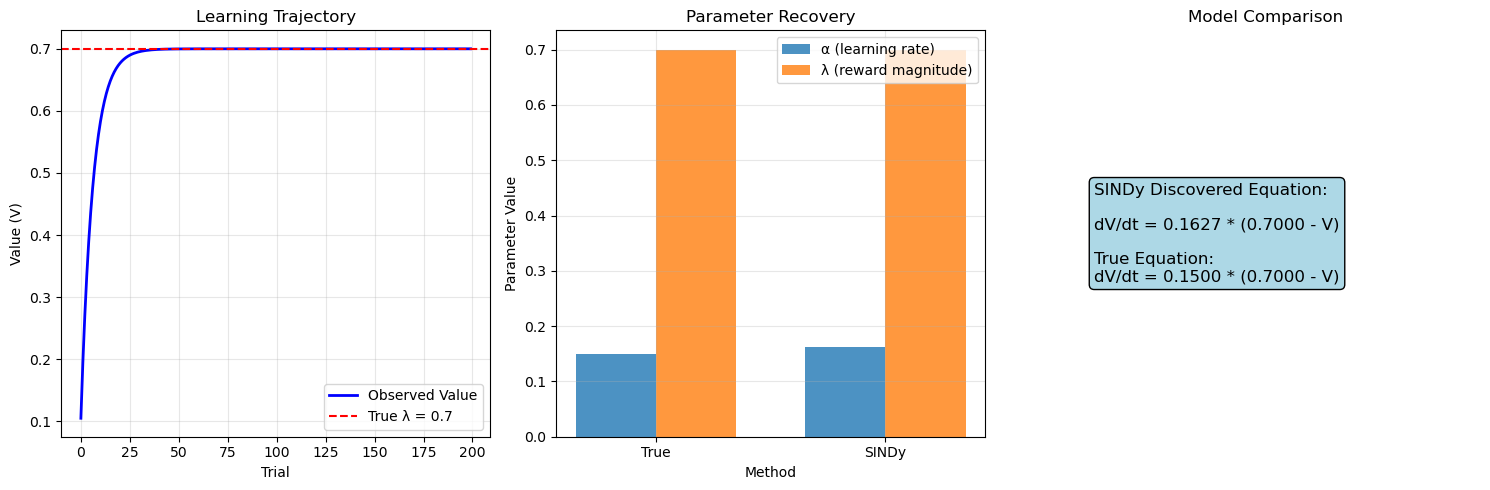

In [24]:
# Visualize the results
plt.figure(figsize=(15, 5))

# Plot 1: Learning trajectory
plt.subplot(1, 3, 1)
plt.plot(sindy_results['time'], sindy_results['value'], 'b-', linewidth=2, label='Observed Value')
plt.axhline(y=true_lambda, color='r', linestyle='--', label=f'True λ = {true_lambda}')
plt.xlabel('Trial')
plt.ylabel('Value (V)')
plt.title('Learning Trajectory')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Parameter comparison
plt.subplot(1, 3, 2)
methods = ['True', 'SINDy']
alpha_values = [true_alpha, sindy_results['recovered_alpha']]
lambda_values = [true_lambda, sindy_results['recovered_lambda']]

x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, alpha_values, width, label='α (learning rate)', alpha=0.8)
plt.bar(x + width/2, lambda_values, width, label='λ (reward magnitude)', alpha=0.8)
plt.xlabel('Method')
plt.ylabel('Parameter Value')
plt.title('Parameter Recovery')
plt.xticks(x, methods)
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: SINDy model equation
plt.subplot(1, 3, 3)
equation_text = f"SINDy Discovered Equation:\n\ndV/dt = {sindy_results['recovered_alpha']:.4f} * ({sindy_results['recovered_lambda']:.4f} - V)\n\nTrue Equation:\ndV/dt = {true_alpha:.4f} * ({true_lambda:.4f} - V)"
plt.text(0.1, 0.5, equation_text, fontsize=12, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Model Comparison')
plt.axis('off')

plt.tight_layout()
plt.show()
